Saving colorful-background-texture-multi-color-orange-illustration-3840x2715-3104.jpg to colorful-background-texture-multi-color-orange-illustration-3840x2715-3104.jpg
Imagen cargada como NumPy array. Forma (H, W, C): 2715x3840x3


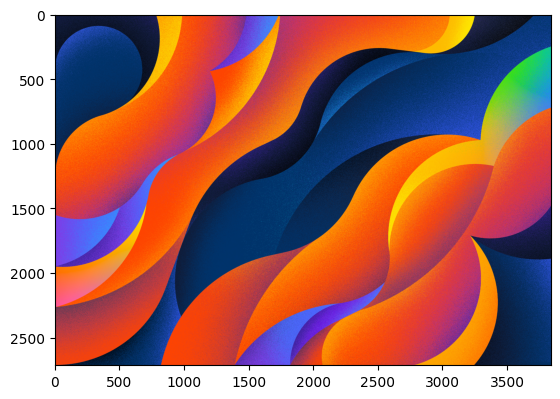

In [2]:
import cv2
import cupy as cp
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# ====================================================================
# --- 1. Cargar Imagen (CPU) ---
# ====================================================================

""" Cada pixel de la imagen tendra los 3 colores RGB con rangos de valores [0.0 a 1.0] """

uploaded = files.upload()

img_name = list(uploaded.keys())[0]
img = cv2.imread(img_name)
img_cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_np = img_cv_rgb.astype(np.float32) / 255.0
H, W, C = img_np.shape
print(f"Imagen cargada como NumPy array. Forma (H, W, C): {H}x{W}x{C}")

plt.imshow(img_np)
plt.show()

In [3]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import time

import numpy as np
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 # resuelve bug de versiones

In [4]:
# ====================================================================
# --- 2. Crear Kernel (GPU) ---
# ====================================================================

@cuda.jit
def grayscale_kernel_1D(img_color, img_gray):
    """
    Kernel 1D que mapea un índice lineal (idx) a coordenadas 2D (i, j).
    Esto elimina la ambigüedad del orden (Ancho, Alto) del lanzamiento.
    """
    # Obtener el índice lineal del píxel
    idx = cuda.grid(1)

    # Obtener las dimensiones de la imagen de salida
    rows, cols = img_gray.shape
    total_pixels = rows * cols

    # Chequeo de límites (para el índice lineal)
    if idx < total_pixels:
        # Mapeo de índice 1D (idx) a coordenadas 2D (i, j)
        i = idx // cols  # Fila (Alto)
        j = idx % cols   # Columna (Ancho)

        R = img_color[i, j, 0]
        G = img_color[i, j, 1]
        B = img_color[i, j, 2]

        # 3. Cálculo de la intensidad de gris
        gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B

        # 4. Asignar el valor de gris al array de salida
        img_gray[i, j] = gray_value

In [5]:
# ====================================================================
# --- 3. Preparación de la Imagen (CPU) ---
# ====================================================================

# Obtener dimensiones
H, W, C = img_np.shape # H = Altura/Filas, W = Ancho/Columnas, C = Canales
print(f"Dimensiones de la imagen (H, W, C): {H}, {W}, {C}")

# Crear array de salida en la CPU (solo filas y columnas, 1 canal)
img_gray_cpu = np.zeros((H, W), dtype=np.float32)

# ====================================================================
# --- 4. Procesamiento Acelerado en la GPU (CUDA 2D) ---
# ====================================================================

# 4.1 Transferir arrays de la CPU a la GPU (Dispositivo)
d_img_color = cuda.to_device(img_np)
d_img_gray = cuda.to_device(img_gray_cpu)

# 4.2 Configurar el lanzamiento del kernel 2D (Grid y Block)

# a. Dimensiones del Bloque
THREADS_PER_BLOCK_1D = 256

# b. Dimensiones de la Rejilla (Grid)
total_pixels = H * W
BLOCKS_PER_GRID_1D = (total_pixels + THREADS_PER_BLOCK_1D - 1) // THREADS_PER_BLOCK_1D

print(f"\nLanzando kernel CUDA con configuración 2D:")
print(f"  Dimensiones de la imagen: {W} x {H}")
print(f"  Hilos por bloque (X, Y): {THREADS_PER_BLOCK_1D}")
print(f"  Bloques por rejilla (X, Y): {BLOCKS_PER_GRID_1D}")

# 4.3 Lanzamiento y Sincronización
start_gpu = time.time()

# Lanzamiento del kernel 2D: [BLOQUES (X, Y), HILOS (X, Y)]
grayscale_kernel_1D[BLOCKS_PER_GRID_1D, THREADS_PER_BLOCK_1D](d_img_color, d_img_gray)

# Esperar a que todos los hilos terminen
cuda.synchronize()
time_gpu = time.time() - start_gpu
print(f"Tiempo de ejecución en GPU: {time_gpu:.4f} segundos")

# 4.4 Mover el resultado de la GPU de vuelta a la CPU
img_gray_gpu_result = d_img_gray.copy_to_host()

Dimensiones de la imagen (H, W, C): 2715, 3840, 3

Lanzando kernel CUDA con configuración 2D:
  Dimensiones de la imagen: 3840 x 2715
  Hilos por bloque (X, Y): 256
  Bloques por rejilla (X, Y): 40725
Tiempo de ejecución en GPU: 1.2534 segundos


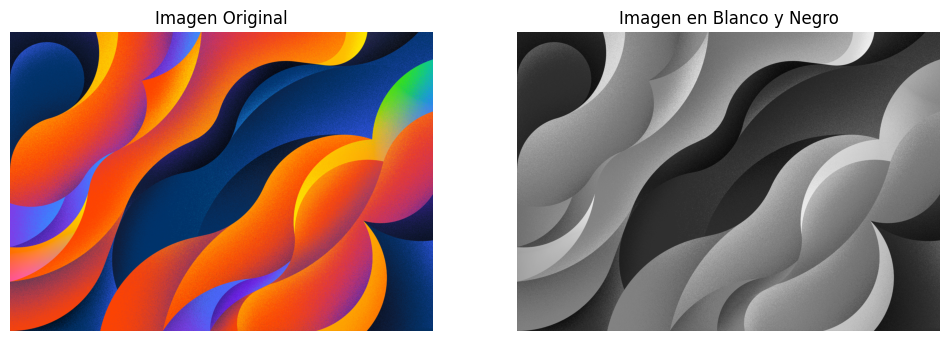

In [6]:
# ====================================================================
# --- 5. Visualización del Resultado ---
# ====================================================================

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_gray_gpu_result, cmap='gray')
plt.title("Imagen en Blanco y Negro")
plt.axis('off')
plt.show()